<a href="https://colab.research.google.com/github/babsyco/CNN_CIFAR10_study/blob/master/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 Report
## Daniel Babekuhl



Please follow the instructions carefully:
- This project is based on Cifar-10 dataset. The basic loading operations are added already. Please do not use other dataset.
- Remove the corresponding `e.g.` and fill in all the blanks in this file, including some codes in Part 1, your choices for Part 2, your task for Part 3, and the analyses for your choices, specification of your computer, etc.
- Please do not change the format of this report.
- In your analyses, you can add math functions and graphs.
- Please make clear comments and references for any codes written by yourself or copied from other sources.

### Part 0: Prepare for Colab

If you work on online GPU servers, e.g. [Google Colab](https://colab.research.google.com), you need to first install PyTorch each time you run the file. You can also upload file and load files from your google drive.
Besides, you can also select GPU as Hardware accelerator in Edit->Notebook settings. 

Remember to run some of the following blocks if you work on Google Colab. You can ignore this part if you are not using Google Colab (e.g, if you are use lab machines, your own computers or AWS servers (Windows)).

In [ ]:
#Apparently this is actually no longer necessary on Colaboratory!

# Install pytorch

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

import torch
print(torch.__version__)

1.2.0


In [ ]:
# upload files to Colab
from google.colab import files
files.upload()

### Part 1: Baseline model
You need to run this model successfully to get the marks. You should finish the codes that are used to split the training dataset into training set (45000 images) and validation set (5000 images) and draw the loss curve for training loss and validation loss. 

### 1.1 prepare data

In [ ]:
# useful packages
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn


In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


0it [00:00, ?it/s]

170500096it [00:04, 42516927.43it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 1.2 split the training data into training and validation
In most of the cases, you are given the test set, so you need to prepare some validation data to evaluate your model during training stage. You need to make a validation dataset that contains 5000 training images, and the rest 45000 images are used as the new training set.

In [ ]:
import numpy as np

# Creates and returns dataLoaders for training and validation.
# Size of trainloader is 90% of train_val_size.
# Size of valloader is 10% of train_val_size.
def create_vt_dataLoaders(train_val_size, batch_size):
  
  #sizes for training and validation datasets
  train_size = int(train_val_size * 0.9)
  val_size = train_val_size - train_size

  #indexes of all train/val data randomised
  all_index = np.random.permutation(train_val_size)

  #first indexes will be for training data, rest are for val data
  train_index = all_index[:train_size].tolist()
  val_index = all_index[train_size:train_size + val_size].tolist()

  #create dataLoaders of validation/training data using SubsetRandomSampler
  val_sampler = torch.utils.data.SubsetRandomSampler(val_index)
  train_sampler = torch.utils.data.SubsetRandomSampler(train_index)
  
  valloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            sampler=val_sampler)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          sampler=train_sampler)
  return trainloader, valloader

# Example of creating dataLoaders (these are re-created in section 1.5)
batch_size = 4
train_val_size = 50000
trainloader, valloader = create_vt_dataLoaders(train_val_size, batch_size)


### 1.3 Define a Baseline Convolution Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Note: network is reset throughout notebook when reset_network function
# is called.
net = Net()


### 1.4 Define a Loss function and optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

#optimizer re-declared in section 1.5
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 1.5 Train the network

In [ ]:
# TRAINING FUNCTIONS

from timeit import default_timer as timer
from datetime import timedelta

# Resets network and optimizer. Returns both.
def reset_network(learning_rate):
  net = Net()
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
  return net, optimizer


# Trains the network for one epoch on trainloader dataset, then validates
# using the valloader dataset. Returns four values:
#  1) train_loss_value: This value is calculated as the average of loss 
#      values for the final 5% of mini-batches of training data.
#  2) train_accuracy_value: percentage correct for the final 5% of
#      mini-batches of training data.
#  3) val_loss_value: After the epoch of training data, the network is run on
#      a single epoch of the validation dataset (without back-propogation). 
#      This value is its average loss.
#  4) val_accuracy_value: percentage correct on valloader dataset.
# Running loss and final loss/accuracy values will also be printed if 
# 'print_log'is set to True.
def train_network_epoch(net, print_log):
  
  #store accuracy data
  train_correct = 0
  train_total = 0
  val_correct = 0
  val_total = 0
  
  #store loss data
  running_loss = 0.0 #for display only
  train_loss_data = []
  val_loss_data = []
  
  #1) TRAIN DATA ON TRAINLOADER DATASET
  for i, data in enumerate(trainloader, 0):
      # get the inputs
      inputs, labels = data
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      #store loss and accuracy values for last 5% of mini-batches
      if i >= len(trainloader) * 0.95:
        #train loss
        train_loss_data.append(loss.item())
        #train accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

      # print running loss
      running_loss += loss.item()
      if print_log:
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d batches] loss: %.3f' %
                 (i + 1, running_loss / 1000))
            running_loss = 0.0

  #calculate loss and accuracy values
  train_loss_value = round(sum(train_loss_data)/len(train_loss_data), 3)
  train_accuracy_value = round(100 * train_correct / train_total, 2)
  
  #2) RUN NETWORK ON VALIDATION DATASET (no back-propogation)
  for i, data in enumerate(valloader, 0):
      # get the inputs
      inputs, labels = data

      #store val loss
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      val_loss_data.append(loss.item())

      #store val accuracy
      _, predicted = torch.max(outputs.data, 1)
      val_total += labels.size(0)
      val_correct += (predicted == labels).sum().item()

  #validation loss and accuracy for this epoch
  val_loss_value = round(sum(val_loss_data)/len(val_loss_data), 3)
  val_accuracy_value = round(100 * val_correct / val_total, 2)
  
  #print loss and accuracy values
  if print_log:
    print('epoch complete.')
    print('training loss:', train_loss_value)
    print('validation loss: ', val_loss_value)
    print('training accuracy: %d%%' % train_accuracy_value)
    print('validation accuracy: %d%%' % val_accuracy_value)

  return train_loss_value, train_accuracy_value, val_loss_value, val_accuracy_value


# Trains network. Returns four lists:
#     train_loss_values, train_acc_values, val_loss_values, val_acc_values 
# Each value in these lists represents one epoch. Prints notification and time 
# taken on finishing. Will also print running loss and final lists if 
# print_log = True.
def train_network(net, epochs, print_log):
  
  start = timer()
  
  #data to be returned
  train_loss_values = []
  train_accuracy_values = []
  val_loss_values = []
  val_accuracy_values = []

  #train/validate network
  for epoch in range(epochs):
    
    if print_log:
      print('\nEPOCH {} OF {}:'.format(epoch + 1, epochs))
    
    #train and validate network for one epoch
    a,b,c,d = train_network_epoch(net, print_log)
    
    #add loss/accuracy data to lists
    train_loss_values.append(a)
    train_accuracy_values.append(b)
    val_loss_values.append(c)
    val_accuracy_values.append(d)
  
  #time taken to train
  end = timer()
  
  #Finish notification
  print('\nFINISHED TRAINING (' + 
          'time: {})'.format(str(timedelta(seconds=(end - start)))))
  if print_log:
    print('  Loss (per epcoch):')
    print('    Train:', train_loss_values)
    print('      Val:', val_loss_values)
    print('  Accuracy (per epcoch):')
    print('    Train:',  train_accuracy_values)
    print('      Val:', val_accuracy_values)

  return train_loss_values, train_accuracy_values, \
     val_loss_values, val_accuracy_values
    

# WRAPPER FUNCTIONS FOR LOADING/SAVING PARAMETERS

# Save parameters (must also download a local copy!)  
def save_params(PATH):
  if PATH:
    torch.save(net.state_dict(), params_file)
  
# Load network parameters - make sure it is the right network!
def load_params(PATH):
  if PATH:
    net.load_state_dict(torch.load(PATH))

In [ ]:
# TRAIN NETWORK PART 1

#print realtime log
print_log = True

# Parameters
train_val_size = 50000 #can be reduced to speed up training
batch_size = 4
epochs = 16
learning_rate = 0.001

# Create dataLoaders
trainloader, valloader = create_vt_dataLoaders(train_val_size, batch_size)

# Reset network
net, optimizer = reset_network(learning_rate)

# Train 
train_loss, train_acc, val_loss, val_acc = train_network(net, epochs, print_log)

# Save parameters. params_savefile = False or 'FILEPATH'
params_savepath = False
save_params(params_savepath)


EPOCH 1 OF 16:
[1000 batches] loss: 2.303
[2000 batches] loss: 2.300
[3000 batches] loss: 2.238
[4000 batches] loss: 2.073
[5000 batches] loss: 2.004
[6000 batches] loss: 1.944
[7000 batches] loss: 1.858
[8000 batches] loss: 1.824
[9000 batches] loss: 1.757
[10000 batches] loss: 1.736
[11000 batches] loss: 1.710
epoch complete.
training loss: 1.697
validation loss:  1.719
training accuracy: 36%
validation accuracy: 37%

EPOCH 2 OF 16:
[1000 batches] loss: 1.656
[2000 batches] loss: 1.666
[3000 batches] loss: 1.611
[4000 batches] loss: 1.596
[5000 batches] loss: 1.564
[6000 batches] loss: 1.556
[7000 batches] loss: 1.533
[8000 batches] loss: 1.511
[9000 batches] loss: 1.525
[10000 batches] loss: 1.450
[11000 batches] loss: 1.470
epoch complete.
training loss: 1.438
validation loss:  1.514
training accuracy: 48%
validation accuracy: 47%

EPOCH 3 OF 16:
[1000 batches] loss: 1.448
[2000 batches] loss: 1.436
[3000 batches] loss: 1.417
[4000 batches] loss: 1.398
[5000 batches] loss: 1.427
[

### 1.6 visualize the loss and accuracy
Using the loss of both training data and validation data to evaluate the model. You may need to change some of the codes in 1.5 in order to save the loss into different lists.

In [ ]:
# PLOTTING FUNCTIONS

import matplotlib.pyplot as plt
import numpy as np

# Plots training and validation data. Args:
#   train_data, val_data: lists of equal length.
#   legend: [train_data_name, val_data_name, location]
#   title, xlabel, ylabel: strings 
def plot_tv_data(train_data, val_data, title, xlabel, ylabel, legend):
  #must create x_values to start at 1
  x_values = list(range(1,len(train_data) + 1))
  
  plt.title(title)
  plt.plot(x_values, train_data, marker='.')
  plt.plot(x_values, val_data, marker='.')
  plt.legend([legend[0], legend[1]],loc=legend[2])
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()


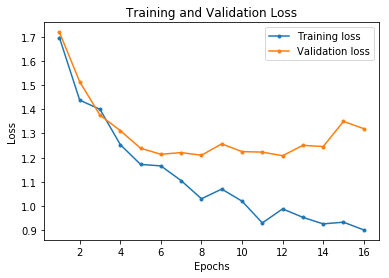

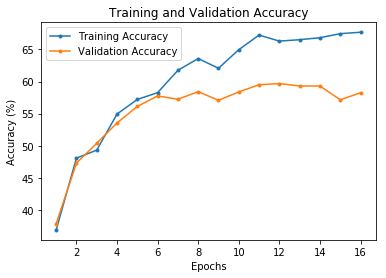

In [ ]:
# PLOT PART 1 DATA 

# Plot loss
title = 'Training and Validation Loss'
xlabel = 'Epochs'
ylabel = 'Loss'
legend = ['Training loss', 'Validation loss', 1]
plot_tv_data(train_loss, val_loss, title, xlabel, ylabel, legend)

#Plot accuracy
title = 'Training and Validation Accuracy'
xlabel = 'Epochs'
ylabel = 'Accuracy (%)'
legend = ['Training Accuracy', 'Validation Accuracy', 2]
plot_tv_data(train_acc, val_acc, title, xlabel, ylabel, legend)


### 1.7 Eval the trained network

In [ ]:
# Load parameters. 
# params_loadfile = False or 'FILEPATH'
params_loadpath = False
load_params(params_loadpath)

# Evaluate network on testLoader
def eval_net(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

eval_net(net, testloader)

Accuracy of the network on the 10000 test images: 58 %


### Part 2: Hyperparameters Selection
Following the instruction file, you need to make choices for each hyperparameters:

1. Batch size:
2. Base learning rate:
3. Number of epochs: 

**Question**: Why do you make such choices? Use some figures, math equations, codes and printout to make analysis.

##### your analysis comes here:
-----
1) My approach to searching this hyperparameter space was:
 
1.   run every combination on a reduced training/validation dataset of 30,000 samples, then find the best single value for accuracy on the validation set.

2.   plot the solution/accuracy curves for the training session of this set of hyperparameters, to make sure it wasn't an outlier, or that the accuracy of the network had converged after fewer epochs.

3.   Re-train the network on the full training/valdation dataset using the best hyperparameters resulting from the step 2 above, then test it on the test set to get an sense of its performance.


4.   Use this as a benchmark to investigate alternative hyperparameter values.




This process was executed in the following code cells (which are followed by further analysis):



In [ ]:
# Your codes here. 
# Please do not define the networks again, just make changes to the training procedure, i.e. in the loop, please go through all the potential choices.
#--------------------------------------

# RUN NETWORK WITH ALL PARAMETER COMBINATIONS
# This cell runs the network with all hyperparamater combinations, and stores 
# the resulting loss and accuracy data (one value per epoch) in a dictionary 
# called 'performances'. Each key:value pair contains the data for the network 
# run with one set of hyperparameters.
# Keys are a string of the format: 'batch_value rate_value epoch_value'.
# Values are a list of lists with the format:
# [
#  [train_loss],
#  [train_acc],
#  [val_loss],
#  [val_acc]
# ]
performances = {}

# Total size of dataset (both train and val)
# Can be reduced to speed up training
train_val_size = 30000

# 'performances' can also be written to a text file on completion by setting:
#      data_file = 'filename.txt' 
# because it takes a long time to do this! Code to re-import the data is in 
# the next cell. 'performances' will not be written to file if: 
#      data_file = False
data_file = 'part2_performances_{}samples.txt'.format(train_val_size)


#---------------------------------
# RUN ALL PARAMETER COMBINATIONS |
#---------------------------------

# Hyperparameter values to try (do not change)
batch_sizes = [2, 4, 8]
learning_rates = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
num_epochs = [1, 2, 4, 8, 16]

i = 0
all_start = timer()

for batch_size in batch_sizes:
  for learning_rate in learning_rates:
    for epoch in num_epochs:
      
      # Create key for this training session
      key = '{} {} {}'.format(batch_size, learning_rate, epoch)
      
      # Create dataLoaders
      trainloader, valloader = create_vt_dataLoaders(train_val_size, batch_size)

      # Reset network
      net, optimizer = reset_network(learning_rate)

      # Train 
      train_loss, train_acc, val_loss, val_acc = train_network(net, 
                                                               epoch, False)
      
      # Store loss and accuracy data for this training session
      performances[key] = [train_loss, train_acc, val_loss, val_acc]
      
      i += 1
      print('Session {} done: \'{}\''.format(i, key))
      

# Finish Notification
all_end = timer()
print('\nFINISHED ALL TRAINING SESSIONS')
print('total time: {}'.format(str(timedelta(seconds=(all_end - all_start)))))
print('total dataset size (train and val): %d' % train_val_size)
print('number of sessions recorded: %d*%d*%d = %d' % (len(batch_sizes), 
      len(learning_rates), len(num_epochs), len(performances)))


# Write data to text file
if data_file:
  with open(data_file, 'w+') as f:
    print(performances, file=f)
    f.close()



FINISHED TRAINING (time: 0:00:43.519930)
Session 1 done: '2 0.005 1'

FINISHED TRAINING (time: 0:01:34.142461)
Session 2 done: '2 0.005 2'

FINISHED TRAINING (time: 0:03:05.784341)
Session 3 done: '2 0.005 4'

FINISHED TRAINING (time: 0:06:22.229594)
Session 4 done: '2 0.005 8'

FINISHED TRAINING (time: 0:13:10.050385)
Session 5 done: '2 0.005 16'

FINISHED TRAINING (time: 0:00:43.048181)
Session 6 done: '2 0.001 1'

FINISHED TRAINING (time: 0:01:25.343835)
Session 7 done: '2 0.001 2'

FINISHED TRAINING (time: 0:02:51.292654)
Session 8 done: '2 0.001 4'

FINISHED TRAINING (time: 0:05:39.079703)
Session 9 done: '2 0.001 8'

FINISHED TRAINING (time: 0:11:16.281273)
Session 10 done: '2 0.001 16'

FINISHED TRAINING (time: 0:00:43.163695)
Session 11 done: '2 0.0005 1'

FINISHED TRAINING (time: 0:01:25.702162)
Session 12 done: '2 0.0005 2'

FINISHED TRAINING (time: 0:02:51.886930)
Session 13 done: '2 0.0005 4'

FINISHED TRAINING (time: 0:05:40.792852)
Session 14 done: '2 0.0005 8'

FINISHED

BEST RESULTS:
Max validation accuracy: hyperparameters = '4 0.0005 16', value = 57.3
Min validation loss: hyperparameters = '4 0.001 8', value = 1.218
Max train accuracy: hyperparameters = '4 0.0005 16', value = 69.81
Min train loss: hyperparameters = '4 0.0005 16', value = 0.838
(note: parameters are 'batch_value lr_value epochs_value')



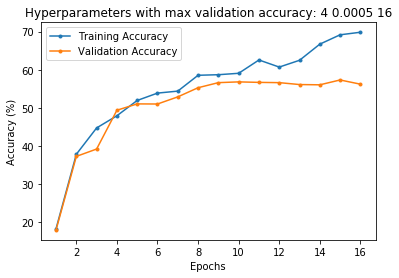

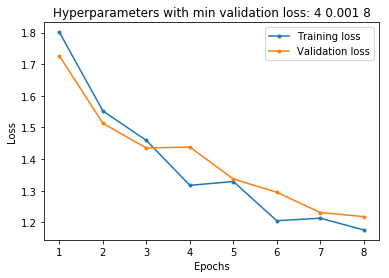

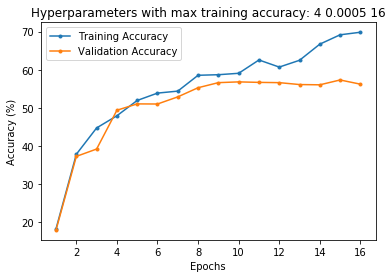

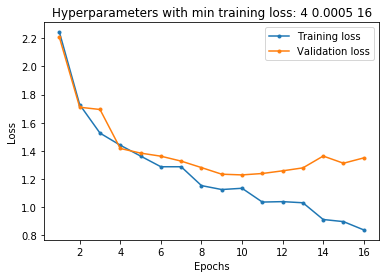

In [ ]:
# ANALYSE AND DISPLAY RESULTS OF HYPERPARAMATER COMBINATIONS

# In this cell the set of hyperparameters that achieved the most desirable
# single values for loss and accuracy are found. The data for these 
# hyperparameter combinations from above is then plotted.

# Restores previous 'performances' dict from file if set to 'filename'.
# Will not restore if set to False:
restore_file = False

if restore_file:
  with open(restore, 'r') as f: 
    content = f.read(); 
    performances = eval(content);


# FIND MIN/MAX VALUES FOR LOSS/ACCURACY
  
# Max accuracy values (train and val)
max_val_acc_value = 0
max_val_acc_key = ''
max_train_acc_value = 0
max_train_acc_key = ''
# Min loss values (train and val)
min_val_loss_value = 1000 #randomly high number for comparison
min_val_loss_key = ''
min_train_loss_value = 1000
min_train_loss_key = ''

# Find values and keys
for key in performances:
  
  # Find min train loss value and key
  temp = min(performances[key][0])
  if temp < min_train_loss_value:
    min_train_loss_value = temp
    min_train_loss_key = key
  
  # find max train accuracy value and key
  temp = max(performances[key][1])
  if temp > max_train_acc_value:
    max_train_acc_value = temp
    max_train_acc_key = key
    
  # Find min val loss value and key
  temp = min(performances[key][2])
  if temp < min_val_loss_value:
    min_val_loss_value = temp
    min_val_loss_key = key
    
  # find max val accuracy value and key
  temp = max(performances[key][3])
  if temp > max_val_acc_value:
    max_val_acc_value = temp
    max_val_acc_key = key


# DISPLAY RESULTS    

print('BEST RESULTS:')
print('Max validation accuracy: hyperparameters = \'{}\', value = {}'.format(
    max_val_acc_key, max_val_acc_value))
print('Min validation loss: hyperparameters = \'{}\', value = {}'.format(
    min_val_loss_key, min_val_loss_value))
print('Max train accuracy: hyperparameters = \'{}\', value = {}'.format(
    max_train_acc_key, max_train_acc_value))
print('Min train loss: hyperparameters = \'{}\', value = {}'.format(
    min_train_loss_key, min_train_loss_value))
print('(note: parameters are \'batch_value lr_value epochs_value\')\n')

# Plots
# Max validation accuracy
xlabel = 'Epochs'
ylabel = 'Accuracy (%)'
legend = ['Training Accuracy', 'Validation Accuracy', 2]
title = 'Hyperparameters with max validation accuracy: ' + max_val_acc_key
train_data = performances[max_val_acc_key][1] #train_acc_data
val_data = performances[max_val_acc_key][3] #val_acc_data
plot_tv_data(train_data, val_data, title, xlabel, ylabel, legend)

# Min validation loss
xlabel = 'Epochs'
ylabel = 'Loss'
legend = ['Training loss', 'Validation loss', 1]
title = 'Hyperparameters with min validation loss: ' + min_val_loss_key
train_data = performances[min_val_loss_key][0] #train_loss_data
val_data = performances[min_val_loss_key][2] #val_loss_data
plot_tv_data(train_data, val_data, title, xlabel, ylabel, legend)

# Max train accuracy
xlabel = 'Epochs'
ylabel = 'Accuracy (%)'
legend = ['Training Accuracy', 'Validation Accuracy', 2]
title = 'Hyperparameters with max training accuracy: ' + max_train_acc_key
train_data = performances[max_train_acc_key][1] #train_acc_data
val_data = performances[max_train_acc_key][3] #val_acc_data
plot_tv_data(train_data, val_data, title, xlabel, ylabel, legend)

# Min training loss
xlabel = 'Epochs'
ylabel = 'Loss'
legend = ['Training loss', 'Validation loss', 1]
title = 'Hyperparameters with min training loss: ' + min_train_loss_key
train_data = performances[min_train_loss_key][0] #train_loss_data
val_data = performances[min_train_loss_key][2] #val_loss_data
plot_tv_data(train_data, val_data, title, xlabel, ylabel, legend)


HYPERPARAMETER COMBINATION WITH THE HIGHEST SINGLE VALUE FOR VALIDATION ACCURACY:
batch size: 4
learning rate: 0.0005
number of epochs: 16

FINISHED TRAINING (time: 0:11:18.382039)



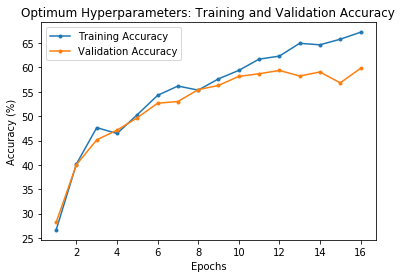

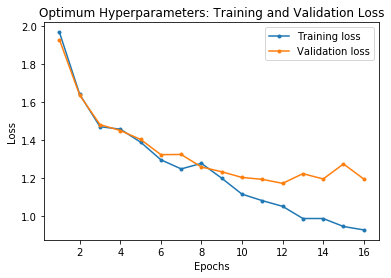

Accuracy of the network on the 10000 test images: 59 %


In [ ]:
# RE-TRAIN NETWORK WITH HYPERPARAMETER COMBINATION THAT ACHIEVED HIGHEST SINGLE 
# VALUE FOR VALIDATION ACCURACY - FIRST ON FULL TRAINING DATASET,
# THEN TEST ON TEST DATASET

# Before running network on test dataset: can automatically re-train network 
# using best hyperparameter combination from above, or just load network 
# parameters from file. To re-train, set:
#      params_loadpath = False 
# or set to 'FILEPATH' to load parameters.
params_loadpath = False

#extract hyperparameters from key
batch_size, learning_rate, epochs = max_val_acc_key.split(' ')
batch_size = int(batch_size)
learning_rate = float(learning_rate)
epochs = int(epochs)

# diplay hyperparameters
print('HYPERPARAMETER COMBINATION WITH THE HIGHEST SINGLE VALUE FOR' + 
     ' VALIDATION ACCURACY:')
print('batch size:', batch_size)
print('learning rate:', learning_rate)
print('number of epochs:', epochs)

print_log = False
train_val_size = 50000

# Create dataLoaders
trainloader, valloader = create_vt_dataLoaders(train_val_size, batch_size)

# Reset network
net, optimizer = reset_network(learning_rate)

#RE-TRAIN OR LOAD PARAMETERS
if params_loadpath:
  load_params(params_loadpath)
else:
  # Train 
  train_loss, train_acc, val_loss, val_acc = train_network(net, 
                                                           epochs, print_log)
  
  
# PLOT DATA 
print('') # just for output spacing

#Plot accuracy
title = 'Optimum Hyperparameters: Training and Validation Accuracy'
xlabel = 'Epochs'
ylabel = 'Accuracy (%)'
legend = ['Training Accuracy', 'Validation Accuracy', 2]
plot_tv_data(train_acc, val_acc, title, xlabel, ylabel, legend)

# Plot loss
title = 'Optimum Hyperparameters: Training and Validation Loss'
xlabel = 'Epochs'
ylabel = 'Loss'
legend = ['Training loss', 'Validation loss', 1]
plot_tv_data(train_loss, val_loss, title, xlabel, ylabel, legend)


# EVALUATE ON TEST DATA
eval_net(net, testloader)

(Analysis continued)<br>
**Regarding epochs**: As can be seen in the plots above, the validation accuracy does not appear to have converged after 8 epochs. Therefore, despite taking longer to train, if maximum accuracy is desired, 16 training epochs can be justified as the best choice, at least given these values for learning rate and batch size. It can also be seen however that overfitting has begun to occur. This is indicated by separation in both plots between the test and validation curves. In practice, it could be argued that the network reaches maximum accuracy after approximately 11 epochs of training (however this was not one of the hyperparameter choices suggested).

intuitively, less than 8 epochs will not produce optimum accuracy, regardless of the other parameters.

**Regarding learning rate**: Changing the learning rate to 0.001 (keeping batch size = 4 and epochs = 16) does not appear to affect the converged accuracy in a very significant way, however after running the network with each value several times, it does appear that a learning rate of 0.001 converges slightly earler (though not within 8 epochs). This can be seen by comparing the plots from part 1 with the plots directly above. Reducing the learning rate below 0.0005 however reduces the maximum accuracy achieved: the network does not have time to reach its maximum within 16 epochs. the same is obviously true of the learning rates less than this.

When the learning rate is set too high, there is too much gradient 'overshoot', that is, it will take a long time to reach a local minima as the updated values will constantly overshoot it, back and forth. A learning rate scheduler (reducing the learning rate as the model trains, producing more fine-grained leaps so the values continue to converge towards the minima), also addresses this issue.

**Regarding batch size:** While reducing the batch size from 4 to 2 lowered the maximum accuracy, increasing it to 8 appeares to very slightly increase it (1 or 2%). It also slows down the learning process however, taking the full 16 epochs to reach maximum accuracy, presumably because there are less iterations.

Regarding the effect of batch size on training time per epoch, there is the potential for it to have a positive or negative effect. A larger batch size reduces the number of iterations per epoch, however, these iterations take longer because of the increased computation. Upon examining the training times above for this network and batch-size options however, it appears that the larger batch sizes reduce training time in this case. The use of a GPU is likely the cause of this.

**Summary to Part 2:** A batch size of 8 trained on 16 epochs appears to eachieve the highest accuracy. The full 16 epochs are required. While there does not appear to be significant difference in final accuracy between learning rates 0.001 and 0.0005, 0.001 appears to converge slightly faster.

**Final Answer**
<br>
Epochs: 16<br>
Batch size: 8<br>
Learning rate: 0.001<br>

**Part 2 Conclusion**<br>
It seems to be difficult to theoretically decide on the best hyperparameter combination as they each involve a trade-off, and affect each other in very complex ways. In this case of a relatively limited hyperparameter space, it is plausible that trial and error could reveal the optimum hyperparameter combination, but some of the differences in values are very marginal. In a more complex network with a wider range of potential hyperparameter values, it seems unlikely that discovering the optimal value combination is actually possible, and differences in outcomes may be more extreme.



### Part 3: More options

Please indicate the **three** tasks you are assigned here:

1) Transformation: RandomCrom/Resize

2) Structure: Pooling method

3) Training procedure: lr_scheduler: Lambda

For your new baseline and the test for different options, you need to write them in **ONE** single `.py` file. You can debug here, but do **NOT** include your codes in the submitted ipynb file. Your codes for this part will be put in the **project1.py** file.

**Question**: how do you define your new baseline and why? Please highlight the differences between your new baseline and the previous baseline.

##### your analysis comes here:
-----
After experimenting with several hyperparameters, it appeared that easiest way to increase the accuracy of the network was to increase the channel number of each layer. While this did increase the time taken to train the network signficantly, the channel number of each layer seemed to linearly map to maximum accuracy level, reducing experimentation time. My final baseline network, which achieves an accuracy of 71% on the test dataset, is:
_____

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 5)
        self.fc1 = nn.Linear(256, 1024) 
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256) 
        self.fc4 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

As can be seen, compared to the baseline network of part 2, there is an additional convolutional layer and an additional fully connected layer (as per the requirements). It is also worth noting that the filter-sizes in the convolutional layers are all odd numbers: this is in order to allow the filters to interpolate to a centre pixel value (https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363), hence reducing distortion that can occur across layers when the filter size is even.

My goal was to achieve an accuracy of >70% using this network and then try to increase it using the three tasks assigned, however I did not anticipate how much longer this larger network would take to train. The loss/validation curves for this baseline network are as follows: 

PART 3 BASELINE MODEL: test set accuracy = 71%


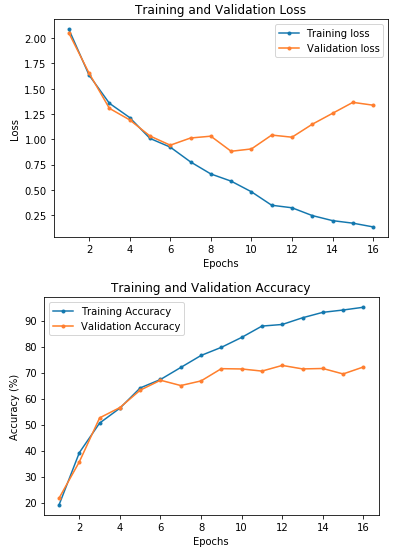

In [ ]:
from IPython.display import Image
print('PART 3 BASELINE MODEL: test set accuracy = 71%')
Image('baseline_loss_acc_curves.png')

So while my baseline network did achieve the required accuracy, it is quite slow and limited my ability to explore the other network features. Also note that it converges on maximum accuracy after approximately 10 epochs, however 16 are plotted for comparision with other feature modifications that follow. The training parameters were as follows:
* batch size = 4
* learning rate = 0.0005
* train dataset = 50,000
* epochs = 16

This bassline network was then run with variants of each of these tasks implemented, and some interesting insights were gained.

**Question**: how did you test the three tasks and what did you learn? Please use some figures, math equations and output from your codes to make analysis. 

**RandomCrop/Resize:**<br>
revevant code:<br><br>     `transforms.RandomResizedCrop(size=32, scale=(0.08, 1.0)`<br><br>
This transform function applies a randomly sized recrop of the images (as well as resizing them to the original dimensions) each epoch (https://discuss.pytorch.org/t/data-augmentation-in-pytorch/7925/2). This essentially expands the samples the network is exposed to during training, as every epoch is technically a different set of images as seen by the network. The arguments are:<br><br>
`scale` = range of sizes as a ratio of original size.
<br>
`size` = the size to be resized to, ie, the original image size.
<br><br>
The expected effect of this would be to reduce overfitting, as the data is essentially fresh for each epoch and the parameters are not over-optimised for the specific case of a limited training dataset. This can be seen in the loss/accuracy curves below:






PART 3 BASELINE MODEL + resize/crop trainsform: test set accuracy = 56%


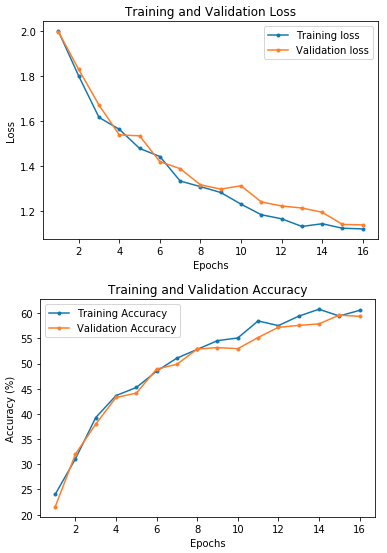

In [ ]:
from IPython.display import Image
print('PART 3 BASELINE MODEL + resize/crop transform: test set accuracy = 56%')
Image('baseline_randcrop_loss_acc_curves.png')

Neither the accuracy or loss curves for validation and training diverge, indicating that there is no overfitting, however, it did not reach the same level of accuracy. After re-training the network for 32 epochs, the maximum validation accuracy had converged to approximately 60%.

The reason for this reduced accuracy performance may be due to the optimal hyperparameter combination not being achieved, or it may possibly be due to the transforms themselves - especially since the original images are of such a small dimension: with so little information in the original images, the transforms may actually lose some of the structures in the images, rather than provide the network with additional permutations of them.<br><br>

**Pooling Method**:<br>
The baseline network achieves >70% accuracy using max-pooling, however two other pooling methods were examined:<br>

AVERAGE POOLING:<br>The relevant code is (within the network):
```
self.pool = nn.AvgPool2d(2, 2)
```
This of course means each feature map is downsampled by taking the average value of the receptor field, instead of the max value. The loss/accuracy curves for the baseline network with average-pooling are as follows:




PART 3 BASELINE MODEL + average pooling: test set accuracy = 70%


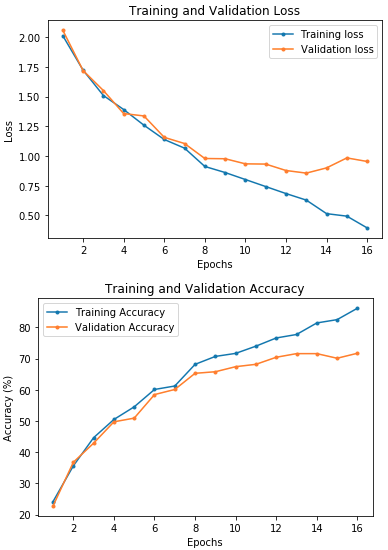

In [ ]:
from IPython.display import Image
print('PART 3 BASELINE MODEL + average pooling: test set accuracy = 70%')
Image('part3_avPooling.png')

This pooling method had the interesting effect of once again reducing over-fitting. One possible explanation for this is that by taking the maximum as a method of downsampling, the network becomes extra-sensive to a particular set of pixels within the training dataset. Taking the average, on the other hand, increases the sensitivity of the network to all the pixels in the images, making it less specialised to a particular set of values.

It did not change the maximum accuracy achieved however, and was notably slower to achieve it than the baseline network.<br><br>

LP_POOLING<br>
Relevant code:


```
self.pool = nn.LPPool2d(2, 2)
```


This function applies the following procedure as a way of downsampling:

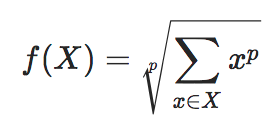

In [ ]:
from IPython.display import Image
Image('lpPool_equation.png',width=180)

Which is further exaggerates the relative significance of the high-value pixels to the final value. The arguments in this function are `(p, kernel_size)`. The loss/accuracy curves for the network when using this pooling method are as follows:

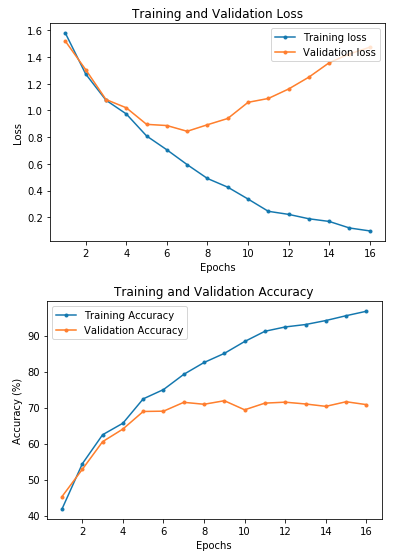

In [ ]:
from IPython.display import Image
Image('lpPool_curves.png')

Interestingly this pooling method caused the network to converge to maximum accuracy earlier without reducing its value - after approximately 7 epochs. One potential explanation for this is the pooling method 'exaggerating' the features of the images, forcing the network to repond to them with heavier weight adjustments. 

**Learning_rate scheduler**<br>
Relevant code:


```
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])
```
`lamba1` is a function that recieves the epoch number, and returns a scalar for the learning rate to be multiplied by (that decrements as the epoch number increases). The logic to a learning rate scheduler is that, as the networks back-propogation converges on a local minima, the learning rate is scaled down to approach the minima in a more fine-grained way, and avoid overshoot. Two different functions for this were tried:


1.   `epoch // 30`
2.   `0.95 ** epoch`

The loss/accuracy curves for each as as follows:





PART 3 BASELINE MODEL + learning rate scheduler: lambda1 = epoch // 30, test set accuracy = 70%


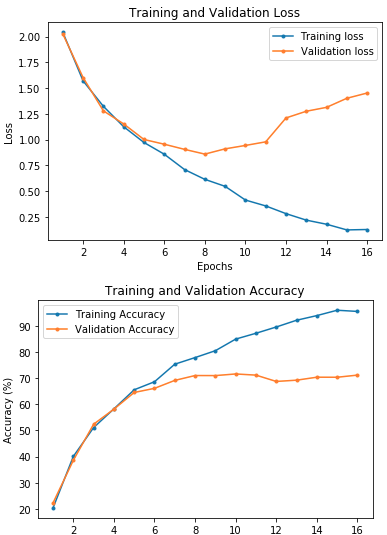

In [ ]:
from IPython.display import Image
print('PART 3 BASELINE MODEL + learning rate scheduler: lambda1 = epoch // 30,' +
       ' test set accuracy = 70%')
Image('lr_30_curves.png')

Despite quite a drastic reduction in learning rate each epoch, this does not appear to have a significant effect on either the converged accuracy or the amount of overfitting. This was a surprising outcome, which may be due the the relatively small number of epochs the network takes to converge. 

PART 3 BASELINE MODEL + learning rate scheduler: lambda1 = 0.95 ** epoch, test set accuracy = 70%


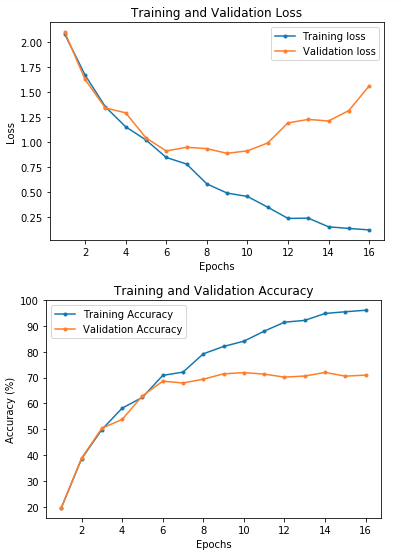

In [ ]:
from IPython.display import Image
print('PART 3 BASELINE MODEL + learning rate scheduler: lambda1 = 0.95 ** epoch,' +
       ' test set accuracy = 70%')
Image('lr_95_curves.png')

Once again, with `lamba1 = 0.95 ** epoch`, there was little impact on both the loss or accuracy of the network as it trained. Once again, this may be due to the short number of epochs the model takes to converge.
<br>
<br>

**Modified Netork**<br>
Disappointingly, none of the network features or hyperparameters explored could improve on my baseline network accuracy, with the possible exception of the pooling methods, which did reduce overfitting and speed up convergence.<br>
Hence the modified network was used to examine what would happen when some of these network features were combined, that is, would they each superimpose their influence on the baseline network, or would the interact in ways that produced some new behaviour. The features and parameters that were used are:<br>


*   Random-sized recrop/resize (as above)
*   Average pooling
*   `lambda1 = epoch // 30`

The resulting loss/accuracy curve for the modified network is as follows:



PART 3 MODIFIED MODEL: test set accuracy = 42%


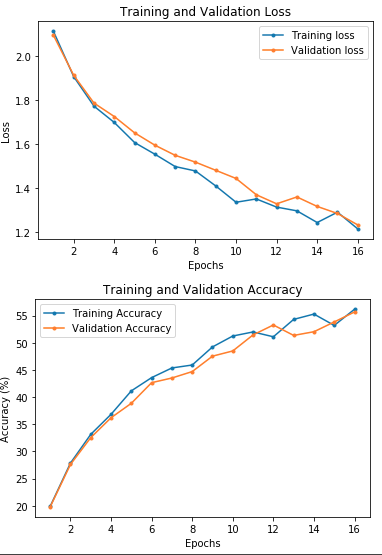

In [ ]:
from IPython.display import Image
print('PART 3 MODIFIED MODEL: test set accuracy = 42%')
Image('modified_curves.png')

As can be seen, the behaviour is similar to the baseline model with the random-crop transformation applied, that is, less overfitting but lower maximum accuracy. One difference however is that it is slightly slower to converge - in fact it took approximately 20 epochs to converge on a value of 59%. It is also possible that the average pooling serves to reduce overfitting, however it is unclear because the lack of overfitting could also be attributed to the random-crop transformation.<br>

One thing to note however is the network's relatively poor performance on the test dataset. With all other network designs and hyperparameters tried, the validation accuracy was a reasonable poxy for the test accuracy. With this modified network however, the test permformance is much lower. This is something I have not been able to explain.
<br><br>


**Conclusion**<br>
There are many, many interacting features to consider when building a deep learning neural network, and while a neural network is highly technical and complex, trial-and-error appears to be a crucial part of effective design. However two very valuable lessons were learned:

* Keep the number of channels down. This allows for quicker back-propogation, shorter training time and hence more experimenting with other features and parameters that might provide better optimisation. 
* Use a validation dataset - this really helps track your networks actual progress during training, and seems to consistently more or less map to how it performs on a test dataset.

It is clear that as well as the technical skill and expertise required, because of the dimensionality of a deep learning neural network, there is a lot of tacit knowledge that can only be acquired through experience building more of them. 

### Specs:
Google Colab GPU: 1xTesla K80 , having 2496 CUDA cores, compute 3.7, 12GB(11.439GB Usable) GDDR5 VRAM.